# Installs and imports

In [1]:
%%capture
!pip uninstall -y numpy grakel
!pip install grakel
!pip install graphein
!pip install numpy==1.23.5
!pip install botorch
!pip install gauche

!pip install mordred

In [ ]:
import botorch
botorch.__version__

MUST RESTART RUNTUIME!!!

In [4]:
# Imports

import warnings
warnings.filterwarnings("ignore") # Turn off Graphein warnings

import time



import numpy as np
from botorch.fit import fit_gpytorch_mll
import gpytorch
from mordred import Calculator, descriptors
from rdkit import Chem
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import torch

from gauche.dataloader import MolPropLoader
from gauche.dataloader.data_utils import transform_data


from gauche import SIGP, NonTensorialInputs
from gauche.kernels.fingerprint_kernels.tanimoto_kernel import TanimotoKernel
from gpytorch.kernels import RQKernel
from gauche.kernels.graph_kernels import WeisfeilerLehmanKernel
from gpytorch.kernels import MaternKernel
from botorch.models import SingleTaskGP
from botorch.models.fully_bayesian import MIN_INFERRED_NOISE_LEVEL
from botorch.models.transforms import Normalize, Standardize
from gpytorch.constraints import GreaterThan
from gpytorch.kernels import ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.priors import GammaPrior
import graphein.molecule as gm
from gauche.dataloader import MolPropLoader
from gauche.dataloader.data_utils import transform_data
from gauche.kernels.string_kernels.sskkernel import pad, encode_string, build_one_hot, SubsequenceStringKernel



import matplotlib.pyplot as plt

font = {'weight' : 'bold',
        'size'   : 42}
plt.rc('font', **font)

import matplotlib
matplotlib.rcParams.update({# Use mathtext, not LaTeX
                            'text.usetex': False,
                            # Use the Computer modern font
                            'font.family': 'serif',
                            'font.serif': 'cmr10',
                            'mathtext.fontset': 'cm',
                            # Use ASCII minus
                            'axes.unicode_minus': False,
                            })

In [5]:
import warnings
warnings.filterwarnings("ignore") # Turn off GPyTorch warnings

from matplotlib import pyplot as plt
%matplotlib inline


from botorch.models.fully_bayesian import SaasFullyBayesianSingleTaskGP
from botorch.models.transforms import Standardize
from botorch.models.transforms import Normalize
from botorch import fit_fully_bayesian_model_nuts

import pickle
import pandas as pd

In [6]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/MyDrive/Colab Notebooks/moldais/'



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/moldais


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tkwargs = {"dtype": torch.float, "device": device}
print(tkwargs)

{'dtype': torch.float32, 'device': device(type='cpu')}


# GP classes

In [ ]:



class MolDAIS_SAAS_GP(SaasFullyBayesianSingleTaskGP):
  def __init__(self, train_x, train_y, likelihood):
    super(MolDAIS_SAAS_GP, self).__init__(train_X=train_x, train_Y=train_y, input_transform=Normalize(d=train_x.size(1)), outcome_transform=Standardize(m=1))

class Mord_Mat_GP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(Mord_Mat_GP, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(MaternKernel(nu=2.5))
    def transform_inputs( x, **kwargs):
        return x
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


class Mord_Mat_PCA_GP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        #print(train_x.shape)
        pca = PCA(n_components=10).fit(train_x)
        train_x_pca = torch.tensor(pca.transform(train_x))
        #print(train_x_pca.shape)
        super(Mord_Mat_PCA_GP, self).__init__(train_x_pca, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(MaternKernel(nu=2.5))
        self.pca = pca
    def transform_inputs( x, **kwargs):
        return x
    def forward(self, x):
        #print(x.shape)
        if x.shape[1]!=10: x = torch.tensor(self.pca.transform(x))
        #print(x.shape)
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class Graph_WL_GP(SIGP):
    def __init__(
        self,
        train_x: NonTensorialInputs,
        train_y: torch.Tensor,
        likelihood: gpytorch.likelihoods.Likelihood,
        **kernel_kwargs,
    ):
        super().__init__(train_x, train_y, likelihood)
        self.mean = gpytorch.means.ConstantMean()
        self.covariance = WeisfeilerLehmanKernel(node_label="element")
    def transform_inputs( x, **kwargs):
        return x
    def forward(self, x):
        mean = self.mean(torch.zeros(len(x), 1))#.float()
        covariance = self.covariance(x)
        jitter = max(covariance.diag().mean().detach().item() * 1e-4, 1e-4)
        covariance += torch.eye(len(x)) * jitter
        return gpytorch.distributions.MultivariateNormal(mean, covariance)


class BOS_Mat_GP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(BOS_Mat_GP, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(MaternKernel(nu=2.5))
    def transform_inputs( x, **kwargs):
        return x
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


class OHE_string_GP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, ):
        likelihood = GaussianLikelihood(
            noise_prior=GammaPrior(torch.tensor(0.9, **tkwargs), torch.tensor(10.0, **tkwargs)),
            noise_constraint=GreaterThan(MIN_INFERRED_NOISE_LEVEL),
            )
        covar_module = ScaleKernel(
            SubsequenceStringKernel(embds, index, alphabet, maxlen, **tkwargs),
            )
        super(OHE_string_GP, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = covar_module
    def transform_inputs( x, **kwargs):
        return x
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


class FP_TM_GP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(FP_TM_GP, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(TanimotoKernel())
    def transform_inputs( x, **kwargs):
        return x
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# generate test predictions accuracy arrays

In [121]:


test = False

WARMUP_STEPS = 8 if test else 128
NUM_SAMPLES  = 4 if test else 64
THINNING     = 16


n_trials = 2 if test else 10

test_set_size = .95


def evaluate_model(X, y, name):
    """Helper function for model evaluation.

    Args:
        X: n x d NumPy array of inputs representing molecules
        y: n x 1 NumPy array of output labels
        use_mordred: Bool specifying whether the X features are mordred descriptors. If yes, then apply PCA.
    Returns:
        regression metrics and confidence-error curve plot.
    """

    # initialise performance metric lists
    r2_list = []
    rmse_list = []
    mae_list = []

    # We pre-allocate array for plotting confidence-error curves

    _, _, _, y_test = train_test_split(X, y, test_size=test_set_size)  # To get test set size
    n_test = len(y_test)

    mae_confidence_list = np.zeros((n_trials, n_test))

    print(f'\nBeginning {name} training loop...')

    for i in range(n_trials):

        print(f'Starting trial {i}')

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size, random_state=i)


        if 'SAAS' not in name and 'Graph' not in name:
          _, y_train, _, y_test, y_scaler = transform_data(X_train, y_train, X_test, y_test)

        if 'Graph' not in name:
          try:
            X_train = torch.tensor(X_train.astype(np.float64))
            X_test = torch.tensor(X_test.astype(np.float64))
          except:
            X_train = torch.tensor(X_train)
            X_test = torch.tensor(X_test)
        else:
          X_train = NonTensorialInputs(X_train)
          X_test = NonTensorialInputs(X_test)

        if 'SAAS' not in name:
          y_train = torch.tensor(y_train).flatten()
          y_test = torch.tensor(y_test).flatten()
        else:
          y_train = torch.tensor(y_train).reshape(-1,1)#.flatten()
          y_test = torch.tensor(y_test).reshape(-1,1)


        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        if name == 'MolDAIS_SAAS':
          print(X_train.shape, y_train.shape)
          model = MolDAIS_SAAS_GP(X_train, y_train.reshape(-1,1), likelihood)
        elif name == 'Mord_Mat_PCA':
          model = Mord_Mat_PCA_GP(X_train, y_train, likelihood)
        elif name == 'Mord_Mat':
          model = Mord_Mat_GP(X_train, y_train, likelihood)
        elif name == 'OHE_string':
          model = OHE_string_GP(X_train, y_train, )
        elif name == 'BOS_Mat':
          model = BOS_Mat_GP(X_train, y_train, likelihood)
        elif name == 'FP_TM':
          model = FP_TM_GP(X_train, y_train, likelihood)
        elif name == 'Graph_WL':
          model = Graph_WL_GP(X_train, y_train, likelihood,)

        if 'SAAS' in name:
          mll = None
          fit_fully_bayesian_model_nuts(model, warmup_steps=WARMUP_STEPS, num_samples=NUM_SAMPLES, thinning=THINNING, disable_progbar=False)
        else:
          mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
          fit_gpytorch_mll(mll)

        if 'SAAS' not in name  :
          model.eval()
          likelihood.eval()
          if 'PCA' not in name:
            try: f_pred = model(X_test)
            except: f_pred = model.forward(X_test)
          else: f_pred = model.forward(torch.tensor(model.pca.transform(X_test)))
          #f_pred = model(X_test
          y_pred = f_pred.mean
          y_var = f_pred.variance

        else:
          with torch.no_grad():
            posterior = model.posterior(X_test)
            y_pred = posterior.mixture_mean
            y_var = posterior.mixture_variance

        if 'SAAS' not in name and 'Graph' not in name:
          y_pred = y_scaler.inverse_transform(y_pred.detach().unsqueeze(dim=1))
          y_test = y_scaler.inverse_transform(y_test.detach().unsqueeze(dim=1))
        else:
          y_pred = y_pred.reshape(-1,1).detach()
          y_test = y_test.reshape(-1,1).detach()

        score = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)

        #try to convert from tensor
        try: y_test = y_test.detach().numpy().flatten()
        except: pass
        try: y_pred = y_pred.detach().numpy().flatten()
        except: pass
        try: y_var = y_var.detach().numpy().flatten()
        except: pass

        try: y_test = y_test.flatten()
        except: pass
        try: y_pred = y_pred.flatten()
        except: pass
        try: y_var = y_var.flatten()
        except: pass



        try: preds4UQ = pd.DataFrame({'target':y_test, 'predicted': y_pred, 'std':y_var**0.5})
        except: import pdb; pdb.set_trace()
        preds4UQ.to_csv(f'predUQ/preds4UQ_{problem}_{name}_{int(test_set_size*100)}_{i}.csv')

        r2_list.append(score)
        rmse_list.append(rmse)
        mae_list.append(mae)

    r2_list = np.array(r2_list)
    rmse_list = np.array(rmse_list)
    mae_list = np.array(mae_list)


    print("\nmean R^2: {:.4f} +- {:.4f}".format(np.mean(r2_list), np.std(r2_list)/np.sqrt(len(r2_list))))
    print("mean RMSE: {:.4f} +- {:.4f}".format(np.mean(rmse_list), np.std(rmse_list)/np.sqrt(len(rmse_list))))
    print("mean MAE: {:.4f} +- {:.4f}\n".format(np.mean(mae_list), np.std(mae_list)/np.sqrt(len(mae_list))))


    mini = np.min([y_test.min(), y_pred.min()] )
    maxi = np.max([y_test.max(), y_pred.max()] )

    #print('min/max = ', mini,'/', maxi, )
    print('\n\n')


    return rmse_list, mae_list, r2_list




# Run

In [135]:
for problem in ['Lipophilicity','ESOL','FreeSolv','Photoswitch']:
  loader = MolPropLoader()
  loader.load_benchmark(problem)
  smiles = loader.features
  print(f"{problem}: {len(smiles)} ")


Lipophilicity: 4200 
ESOL: 1128 
FreeSolv: 642 
Found 13 invalid labels [nan nan nan nan nan nan nan nan nan nan nan nan nan] at indices [41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 158]
To turn validation off, use dataloader.read_csv(..., validate=False).
Photoswitch: 392 


In [122]:
if 0 : #make true if you need the features targets
  for problem in ['Lipophilicity','ESOL','FreeSolv','Photoswitch']:


    loader = MolPropLoader()
    loader.load_benchmark(problem)
    smiles = loader.features
    maxlen = np.max([len(x) for x in smiles])
    alphabet = list({l for word in smiles for l in word})
    embds, index = build_one_hot(alphabet)
    embds = embds.to(**tkwargs)
    X_OHE = torch.cat([pad(encode_string(x, index), maxlen).unsqueeze(0) for x in smiles], dim=0)

    calc = Calculator(descriptors, ignore_3D=True)
    mols = [Chem.MolFromSmiles(smi) for smi in smiles]
    X_mordred = [calc(mol) for mol in mols]
    X_Mord = np.array(X_mordred).astype(np.float64)
    X_Mord = X_Mord[:, ~np.any(np.isnan(X_Mord), axis=0)]

    FP_loader = MolPropLoader()
    FP_loader.load_benchmark(problem)
    FP_loader.featurize('ecfp_fragprints')
    X_FP = FP_loader.features
    y = FP_loader.labels


    Graph_loader = MolPropLoader()
    Graph_loader.load_benchmark(problem)
    graphein_config = gm.MoleculeGraphConfig(
        node_metadata_functions=[gm.total_degree],
        edge_metadata_functions=[gm.add_bond_type],)
    Graph_loader.featurize("molecular_graphs", graphein_config=graphein_config)
    X_graph = Graph_loader.features


    BOS_loader = MolPropLoader()
    BOS_loader.load_benchmark(problem)
    BOS_loader.featurize('bag_of_smiles', max_ngram=5)
    X_BOS = BOS_loader.features



    #Cant pickle X_graph, need to build in real time
    Prob_target_features = {'problem':problem,'y':y, 'X_BOS':X_BOS,'X_FP':X_FP,
                            'X_Mord':X_Mord,'X_OHE':X_OHE }


    save_name = f"{problem}_target_features.pkl"


    with open(save_name, "wb") as f:
        pickle.dump(Prob_target_features, f)

In [ ]:

import pandas as pd

for problem in  ['FreeSolv','Photoswitch','Lipophilicity']:

  #load features/targets
  save_name = f"{problem}_target_features.pkl"
  with open(save_name, "rb") as f:
      Prob_target_features = pickle.load(f)


  X_BOS   = Prob_target_features['X_BOS']
  X_FP    = Prob_target_features['X_FP']
  #X_graph = Prob_target_features['X_graph']
  X_Mord  = Prob_target_features['X_Mord']
  X_OHE   = Prob_target_features['X_OHE']
  y       = Prob_target_features['y']

  Graph_loader = MolPropLoader()
  Graph_loader.load_benchmark(problem)
  graphein_config = gm.MoleculeGraphConfig(
      node_metadata_functions=[gm.total_degree],
      edge_metadata_functions=[gm.add_bond_type],)
  Graph_loader.featurize("molecular_graphs", graphein_config=graphein_config)
  X_graph = Graph_loader.features

  ####### run

  rmse_Graph_WL,     mae_Graph_WL,     r2_Graph_WL     = evaluate_model(X_graph, y, name = 'Graph_WL')
  #rmse_OHE_string,   mae_OHE_string,   r2_OHE_string   = evaluate_model(X_OHE,   y, name = 'OHE_string')
  rmse_Mord_Mat_PCA, mae_Mord_Mat_PCA, r2_Mord_Mat_PCA = evaluate_model(X_Mord,  y, name = 'Mord_Mat_PCA')
  rmse_Mord_Mat,     mae_Mord_Mat,     r2_Mord_Mat     = evaluate_model(X_Mord,  y, name = 'Mord_Mat')
  rmse_BOS_Mat,      mae_BOS_Mat,      r2_BOS_Mat      = evaluate_model(X_BOS,   y, name = 'BOS_Mat')
  rmse_FP_TM,        mae_FP_TM,        r2_FP_TM        = evaluate_model(X_FP ,   y, name = 'FP_TM')
  rmse_MolDAIS_SAAS, mae_MolDAIS_SAAS, r2_MolDAIS_SAAS = evaluate_model(X_Mord,  y, name = 'MolDAIS_SAAS')



  ####### compile results
  #rmse_OHE_string,   mae_OHE_string,   r2_OHE_string = np.zeros

  methods = ['MolDAIS-SAAS', 'Mord-Mat-PCA', 'Mord-Mat', #'OHE-string',
             'BOS-Mat', 'FP-TM', 'Graph-WL',]
  rmse_arrays = [ rmse_MolDAIS_SAAS, rmse_Mord_Mat_PCA, rmse_Mord_Mat,#rmse_OHE_string,
                  rmse_BOS_Mat, rmse_FP_TM, rmse_Graph_WL,]
  mae_arrays = [ mae_MolDAIS_SAAS, mae_Mord_Mat_PCA, mae_Mord_Mat, #mae_OHE_string,
                mae_BOS_Mat, mae_FP_TM, mae_Graph_WL,]
  r2_arrays = [ r2_MolDAIS_SAAS, r2_Mord_Mat_PCA, r2_Mord_Mat, #r2_OHE_string,
              r2_BOS_Mat, r2_FP_TM, r2_Graph_WL,]

  n_trials = len(rmse_MolDAIS_SAAS)

  method_col = np.repeat(methods, [len(arr) for arr in rmse_arrays])
  rmse_col   = np.concatenate(rmse_arrays)
  mae_col    = np.concatenate(mae_arrays)
  r2_col     = np.concatenate(r2_arrays)

  summary_df = pd.DataFrame({ 'method':method_col, 'RMSE':rmse_col,
                            'MAE':mae_col, 'R2':r2_col,})

  summary_df.to_csv(f"PredictionAccuracy_{problem}_{int(test_set_size*100)}.csv")




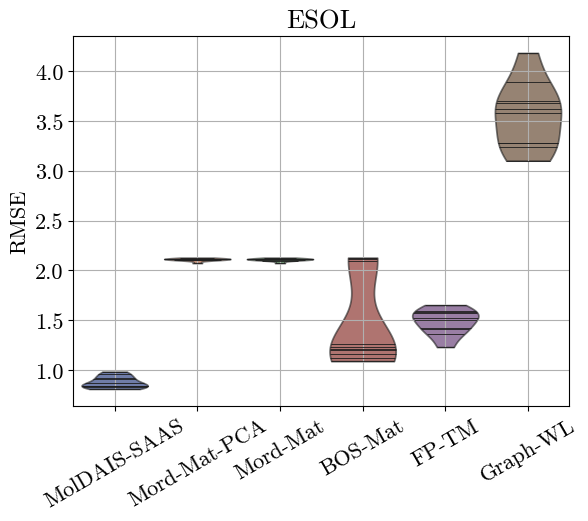

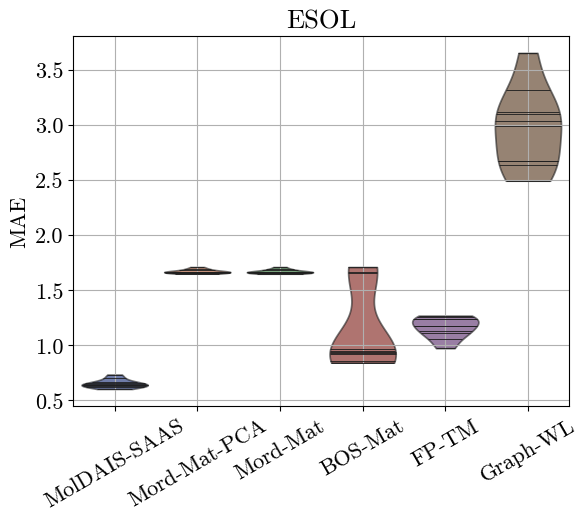

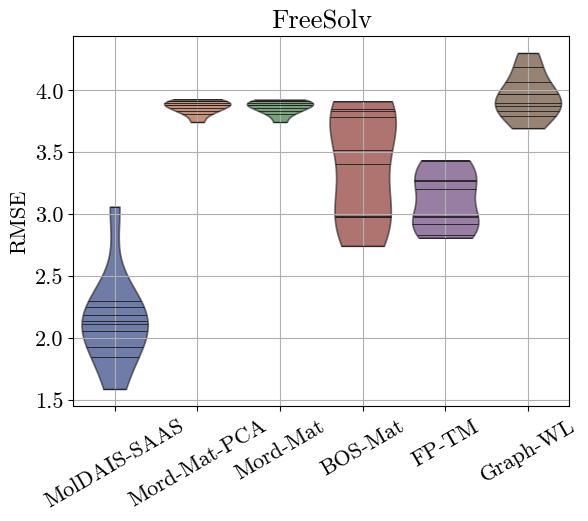

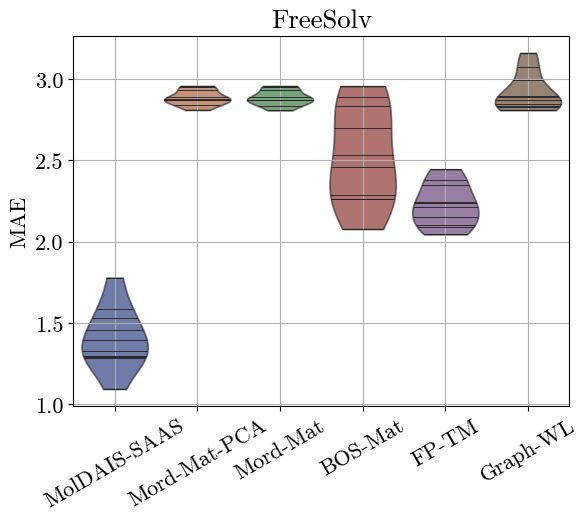

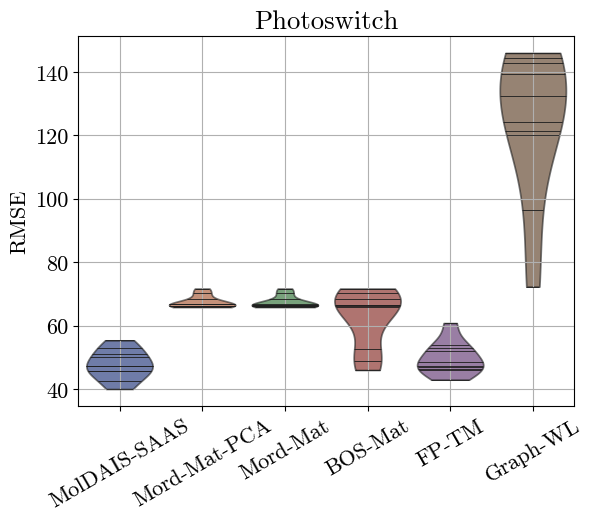

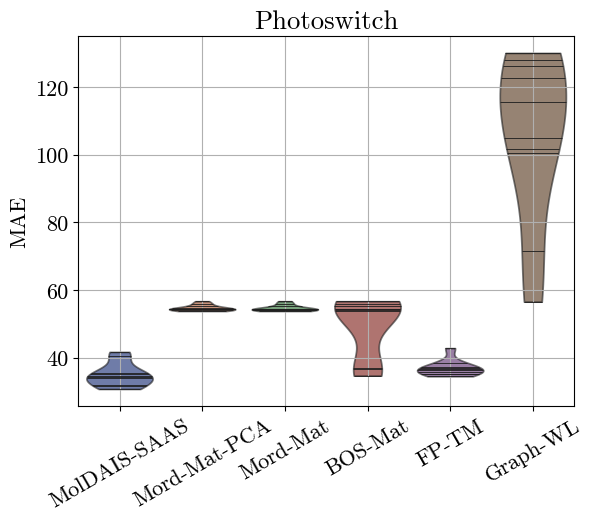

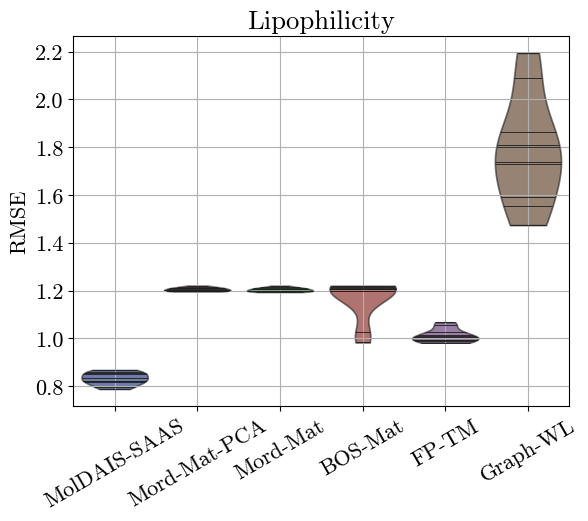

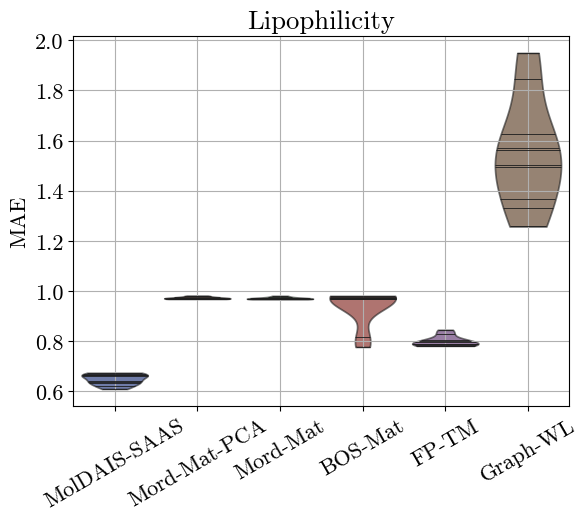

In [134]:
test_set_size = 0.95
font = {'weight' : 'bold',
        'size'   : 16}
plt.rc('font', **font)


for problem in  ['ESOL','FreeSolv','Photoswitch','Lipophilicity']:
  summary_df = pd.read_csv(f"PredictionAccuracy_{problem}_{int(test_set_size*100)}.csv")

  import seaborn as sns
  plt.figure()
  g = sns.violinplot(data=summary_df,x="method", #errorbar='sd',
                  y="RMSE",palette="dark", alpha=.6,inner='stick',cut=0 )#height=6,aspect=1.2)
  plt.xticks(rotation=30)
  plt.xlabel('')
  plt.title(problem)
  plt.grid(True)
  #plt.tight_layout()
  plt.savefig('./PredictionAccuracyPlot_'+problem + f'_RMSE_{int(test_set_size*100)}.png', dpi=300)


  plt.figure()
  g = sns.violinplot(data=summary_df,x="method", y="MAE", #errorbar='sd',
                  palette="dark", alpha=.6, inner='stick',cut=0)#height=6,aspect=1.2)
  plt.xticks(rotation=30)
  plt.xlabel('')
  plt.title(problem)
  plt.grid(True)
  #plt.tight_layout()
  plt.savefig('./PredictionAccuracyPlot_'+problem + f'_MAE_{int(test_set_size*100)}.png',dpi=300 )
